In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()
import gc
gc.collect()

0

In [2]:
import os
import shutil

# Path to the output directory
output_dir = '/kaggle/working/'

# Iterate through all files and directories in the output directory
for filename in os.listdir(output_dir):
    file_path = os.path.join(output_dir, filename)
    try:
        # Check if it is a file or directory
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directory
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

print("Output directory cleaned!")


Output directory cleaned!


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

class segDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = glob(os.path.join(image_dir, '*.png'))
        self.BGR_classes = {'road' : np.array([128, 64, 128], dtype=np.uint8),        # gray-purple
                            'sidewalk' : np.array([244, 35, 232], dtype=np.uint8),    # pink
                            'building' : np.array([70, 70, 70], dtype=np.uint8),      # dark gray
                            'wall' : np.array([102, 102, 156], dtype=np.uint8),       # light gray-blue
                            'fence' : np.array([190, 153, 153], dtype=np.uint8),      # light gray-pink
                            'pole' : np.array([153, 153, 153], dtype=np.uint8),       # light gray
                            'traffic light' : np.array([250, 170, 30], dtype=np.uint8),# orange
                            'traffic sign' : np.array([220, 220, 0], dtype=np.uint8), # yellow
                            'vegetation' : np.array([107, 142, 35], dtype=np.uint8),  # green
                            'terrain' : np.array([152, 251, 152], dtype=np.uint8),    # light green
                            'sky' : np.array([70, 130, 180], dtype=np.uint8),         # light blue
                            'person' : np.array([220, 20, 60], dtype=np.uint8),       # red
                            'rider' : np.array([255, 0, 0], dtype=np.uint8),          # blue
                            'car' : np.array([0, 0, 142], dtype=np.uint8),            # dark blue
                            'truck' : np.array([0, 0, 70], dtype=np.uint8),           # dark gray-blue
                            'bus' : np.array([0, 60, 100], dtype=np.uint8),           # dark blue-green
                            'train' : np.array([0, 80, 100], dtype=np.uint8),         # dark blue-green
                            'motorcycle' : np.array([0, 0, 230], dtype=np.uint8),     # bright blue
                            'bicycle' : np.array([119, 11, 32], dtype=np.uint8),      # dark red
                            'unknown' : np.array([0, 0, 0], dtype=np.uint8)           # black 
                           } # Same as before
        self.bin_classes = list(self.BGR_classes.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = img_path.replace(self.image_dir, self.mask_dir)
        image = plt.imread(img_path)[:,:,:3]
        mask = plt.imread(mask_path)[:,:,:3] * 255
        label_matrix = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        for class_name, bgr_value in self.BGR_classes.items():
            class_index = self.bin_classes.index(class_name)
            mask_indices = np.all(mask == bgr_value, axis=-1)
            label_matrix[mask_indices] = class_index
        image = np.moveaxis(image, -1, 0)
        return torch.tensor(image).float(), torch.tensor(label_matrix, dtype=torch.int64)


In [4]:
from glob import glob  # Import glob function directly
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Paths
train_images_path = '/kaggle/input/png-images-new/new/train_png_1000'
train_masks_path = '/kaggle/input/png-images-new/new/train_png_masks_1000'
val_day_images_path = '/kaggle/input/png-images-new/new/val_png_images_250'
val_day_masks_path = '/kaggle/input/png-images-new/new/val_png_masks_250'
val_night_images_path = '/kaggle/input/png-images-new/new/val__night_png_images_250'
val_night_masks_path = '/kaggle/input/masksnew/val__night_png_masksnew_250'
val_cyclegan_images_path = '/kaggle/input/daynew/daynew'
val_cyclegan_masks_path = '/kaggle/input/masksnew/val__night_png_masksnew_250'

# Dataset instances
train_dataset = segDataset(train_images_path, train_masks_path)
val_day_dataset = segDataset(val_day_images_path, val_day_masks_path)
val_night_dataset = segDataset(val_night_images_path, val_night_masks_path)
val_cyclegan_dataset = segDataset(val_cyclegan_images_path, val_cyclegan_masks_path)

print('Number of train data :', len(train_dataset))
print('Number of test data(day) :', len(val_day_dataset))
print('Number of test data(night) :', len(val_night_dataset))
print('Number of test data(cyclegan) :', len(val_cyclegan_dataset))


# Dataloaders
BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_day_dataloader = DataLoader(val_day_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)
test_night_dataloader = DataLoader(val_night_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)
test_cyclegan_dataloader = DataLoader(val_cyclegan_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)


Number of train data : 1000
Number of test data(day) : 250
Number of test data(night) : 250
Number of test data(cyclegan) : 250


In [5]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.ConvTranspose2d(ch_in, ch_out, kernel_size=2, stride=2)

    def forward(self, x):
        return self.up(x)

class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()

        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )

        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )

        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return psi * x

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=20, in_channel=3, out_channel=20):
        super().__init__()

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)

        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)

        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)

        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)

        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)

        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)

        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)

        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)

        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)

        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)

        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.upconv5(d5)

        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.upconv4(d4)

        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.upconv3(d3)

        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.upconv2(d2)

        d1 = self.conv_1x1(d2)

        return d1

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = F.log_softmax(inputs, dim=1)
        logpt = torch.gather(logpt, 1, targets.unsqueeze(1))
        logpt = logpt.squeeze(1)
        pt = torch.exp(logpt)
        loss = -1 * ((1 - pt) ** self.gamma) * logpt * self.alpha
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

def mIoU(preds, labels, num_classes=20):
    preds = torch.argmax(preds, dim=1)
    total_iou = 0
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union != 0:
            total_iou += intersection / union
    return total_iou / num_classes

def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float().sum()
    total = labels.numel()
    return correct / total



In [7]:
import torch
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import models

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup with updated 'weights' argument
model = models.segmentation.deeplabv3_resnet101(weights="DEFAULT")
model = model.to(device)  # Move the model to the device

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = FocalLoss(reduction='mean').to(device)

# Training settings
N_EPOCHS = 100
plot_losses = []
scheduler_counter = 0
min_loss = float('inf')

# Training loop
# Directory to save checkpoints
checkpoint_dir = '/kaggle/working/'  # Change this if needed

# Training loop
for epoch in range(N_EPOCHS):
    model.train()
    loss_list = []
    acc_list = []

    for batch_i, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)  # Move data to the appropriate device

        # Forward pass
        pred_mask = model(x)['out']  # Use the 'out' key for segmentation models
        loss = criterion(pred_mask, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect metrics
        loss_list.append(loss.item())
        acc_list.append(accuracy(pred_mask, y).item())

        # Print progress
        print(
            "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Accuracy: %f]"
            % (
                epoch + 1,
                N_EPOCHS,
                batch_i + 1,
                len(train_dataloader),
                loss.item(),
                np.mean(loss_list),
                np.mean(acc_list)
            ),
            end=""
        )
    print()  # Newline after each epoch

    # Save checkpoint every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint_path = f"{checkpoint_dir}checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': np.mean(loss_list),  # Save mean loss for the epoch
        }, checkpoint_path)
        print(f"Checkpoint saved at: {checkpoint_path}")



Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 192MB/s]  
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/100] [Batch 250/250] [Loss: 0.191005 (0.272710), Accuracy: 0.492385]
[Epoch 2/100] [Batch 250/250] [Loss: 0.178924 (0.191798), Accuracy: 0.609246]
[Epoch 3/100] [Batch 250/250] [Loss: 0.170776 (0.178684), Accuracy: 0.633959]
[Epoch 4/100] [Batch 250/250] [Loss: 0.127160 (0.171730), Accuracy: 0.651782]
[Epoch 5/100] [Batch 250/250] [Loss: 0.115498 (0.160976), Accuracy: 0.671482]
[Epoch 6/100] [Batch 250/250] [Loss: 0.138199 (0.154961), Accuracy: 0.684748]
[Epoch 7/100] [Batch 250/250] [Loss: 0.240048 (0.147648), Accuracy: 0.697917]
[Epoch 8/100] [Batch 250/250] [Loss: 0.162094 (0.142204), Accuracy: 0.710431]
[Epoch 9/100] [Batch 250/250] [Loss: 0.127428 (0.138239), Accuracy: 0.718827]
[Epoch 10/100] [Batch 250/250] [Loss: 0.123705 (0.133687), Accuracy: 0.726522]
[Epoch 11/100] [Batch 250/250] [Loss: 0.090132 (0.131842), Accuracy: 0.726935]
[Epoch 12/100] [Batch 250/250] [Loss: 0.135661 (0.126139), Accuracy: 0.740570]
[Epoch 13/100] [Batch 250/250] [Loss: 0.193468 (0.125190), Ac

In [9]:
# Assume 'model' is your model instance
model_save_path = "/kaggle/working/deeplabV3.pth"
torch.save(model.state_dict(), model_save_path)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.segmentation.deeplabv3_resnet101(weights="DEFAULT")

In [11]:
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode

<ipython-input-11-c0f8c3d55b6a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [12]:
import torch

# Function to calculate accuracy
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float().sum()
    total = labels.numel()
    return correct / total

# Calculate overall accuracy and mIoU across the test set
def evaluate_model(model, dataloader, num_classes=20):
    model.eval()
    total_accuracy = 0
    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)

            # Forward pass through the model and extract "out" key
            outputs = model(inputs)["out"]

            total_accuracy += accuracy(outputs, labels).item()
            num_batches += 1

    # Calculate average metrics over all batches
    avg_accuracy = total_accuracy / num_batches

    print(f"Overall Accuracy: {avg_accuracy * 100:.2f}%")

# Example usage
evaluate_model(model, test_day_dataloader, num_classes=20)


Overall Accuracy: 79.52%


In [13]:
# Example usage
evaluate_model(model, test_night_dataloader, num_classes=20)


Overall Accuracy: 54.84%


In [14]:
# Example usage
evaluate_model(model, test_cyclegan_dataloader, num_classes=20)


Overall Accuracy: 57.43%


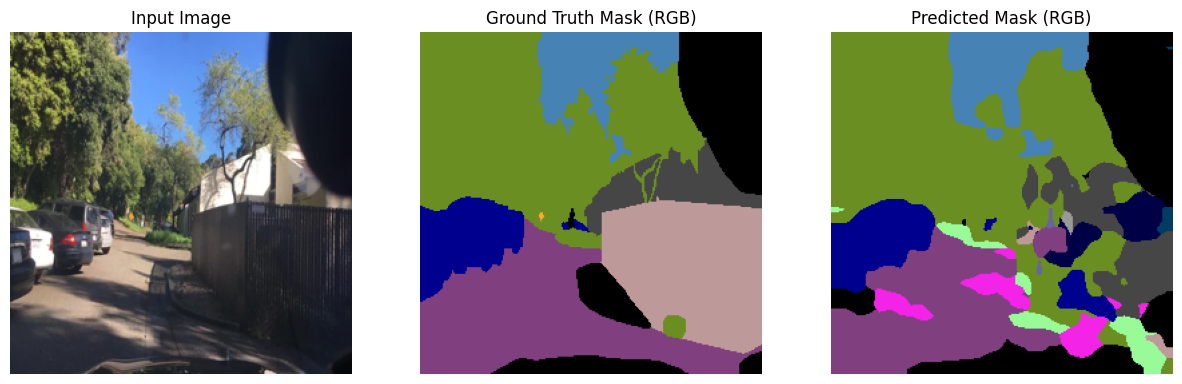

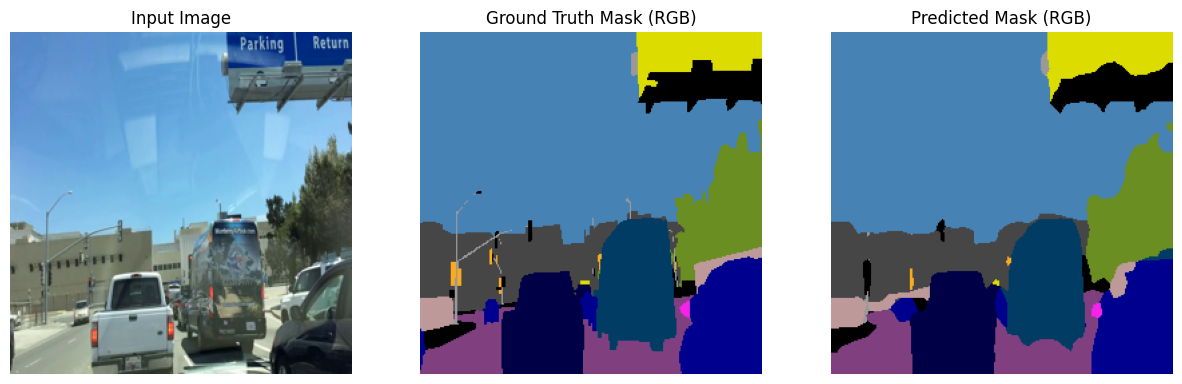

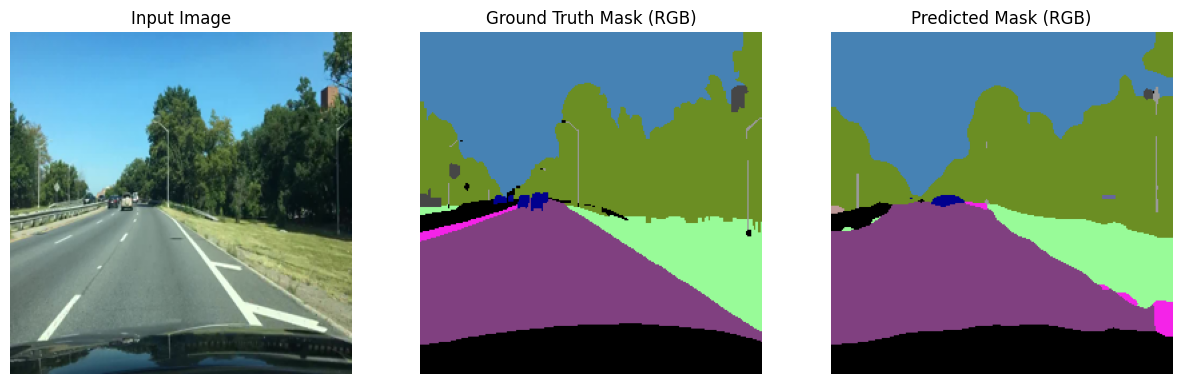

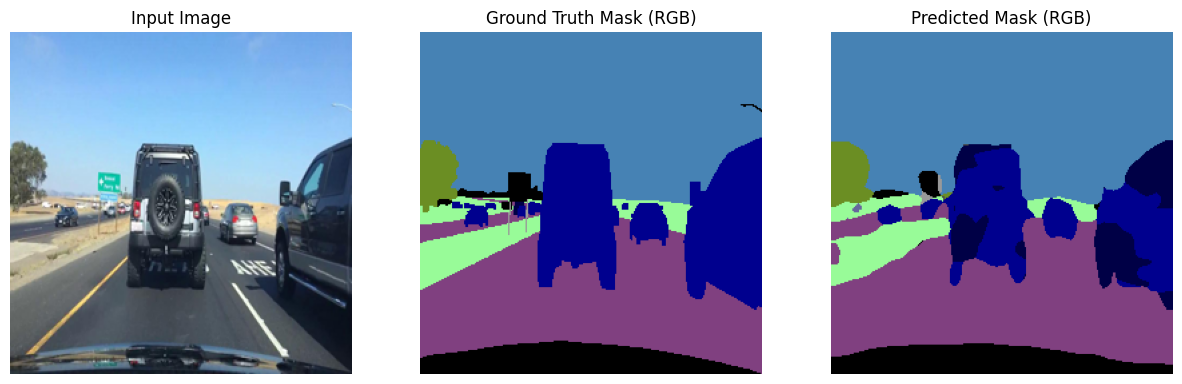

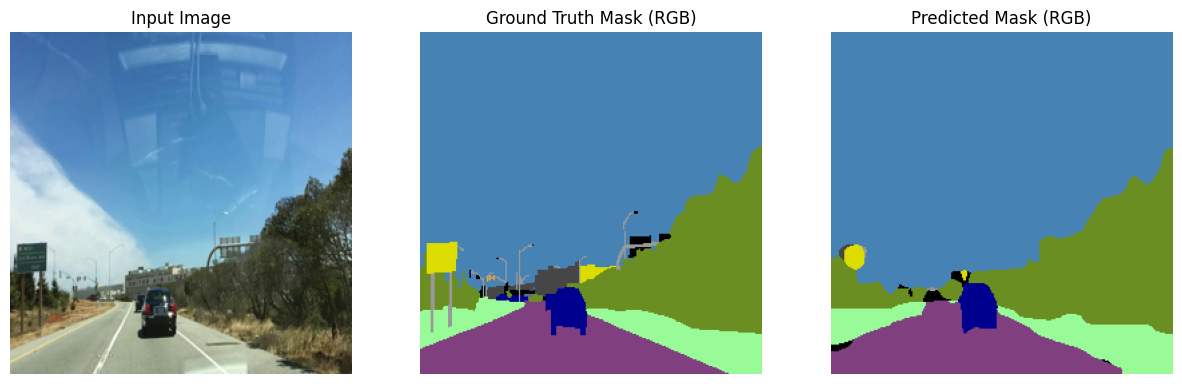

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Mapping from class indices to RGB colors
class_color_map = {
    0: [128, 64, 128],    # road
    1: [244, 35, 232],    # sidewalk
    2: [70, 70, 70],      # building
    3: [102, 102, 156],   # wall
    4: [190, 153, 153],   # fence
    5: [153, 153, 153],   # pole
    6: [250, 170, 30],    # traffic light
    7: [220, 220, 0],     # traffic sign
    8: [107, 142, 35],    # vegetation
    9: [152, 251, 152],   # terrain
    10: [70, 130, 180],   # sky
    11: [220, 20, 60],    # person
    12: [255, 0, 0],      # rider
    13: [0, 0, 142],      # car
    14: [0, 0, 70],       # truck
    15: [0, 60, 100],     # bus
    16: [0, 80, 100],     # train
    17: [0, 0, 230],      # motorcycle
    18: [119, 11, 32],    # bicycle
    19: [0, 0, 0]         # unknown
}

def decode_segmentation(mask):
    # Convert the single-channel mask to an RGB image using the color map
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in class_color_map.items():
        rgb_mask[mask == class_idx] = color
    return rgb_mask

def visualize_predictions_rgb(model, dataloader, num_classes, max_images=5):
    model.eval()
    device = next(model.parameters()).device
    count = 0
    
    with torch.no_grad():
        for batch in dataloader:
            # Assume batch contains (inputs, masks)
            inputs, masks = batch
            inputs = inputs.to(device)
            masks = masks.cpu().numpy()
            
            # Access the "out" key for DeepLabV3 output
            outputs = model(inputs)["out"].argmax(1).cpu().numpy()
            
            for i in range(inputs.shape[0]):
                if count >= max_images:
                    return  # Stop after showing max_images
                
                input_img = inputs[i].permute(1, 2, 0).cpu().numpy()
                gt_mask_rgb = decode_segmentation(masks[i])
                pred_mask_rgb = decode_segmentation(outputs[i])

                # Plot input, ground truth, and predicted masks
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(input_img)
                ax[0].set_title("Input Image")
                ax[0].axis("off")
                
                ax[1].imshow(gt_mask_rgb)
                ax[1].set_title("Ground Truth Mask (RGB)")
                ax[1].axis("off")
                
                ax[2].imshow(pred_mask_rgb)
                ax[2].set_title("Predicted Mask (RGB)")
                ax[2].axis("off")
                
                plt.show()
                
                count += 1

# Example usage:
num_classes = 20  # Adjust as per your dataset
visualize_predictions_rgb(model, test_day_dataloader, num_classes, max_images=5)


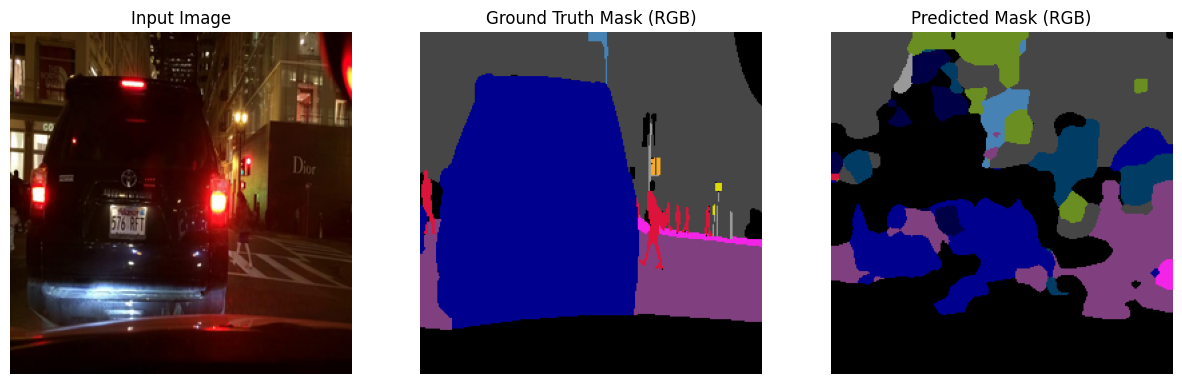

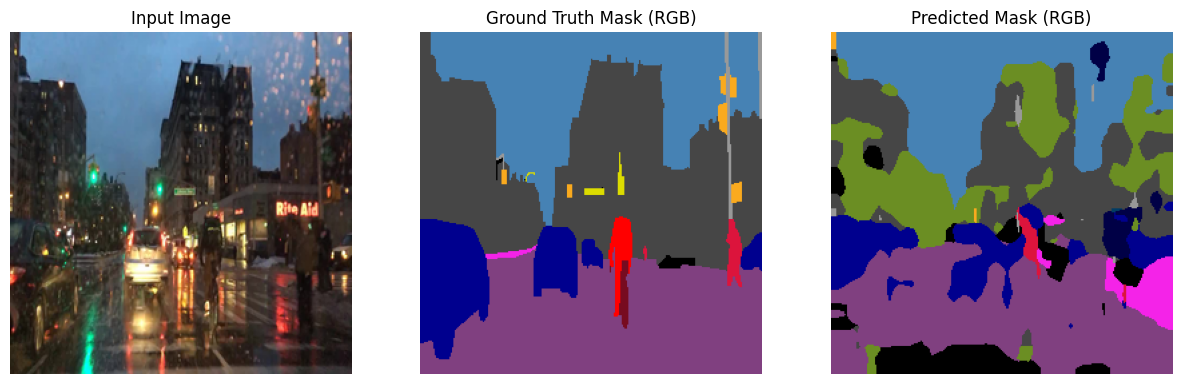

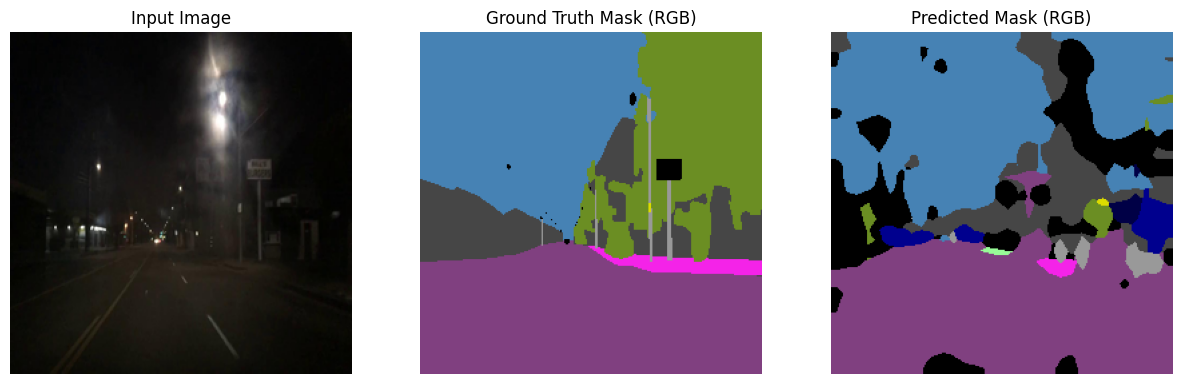

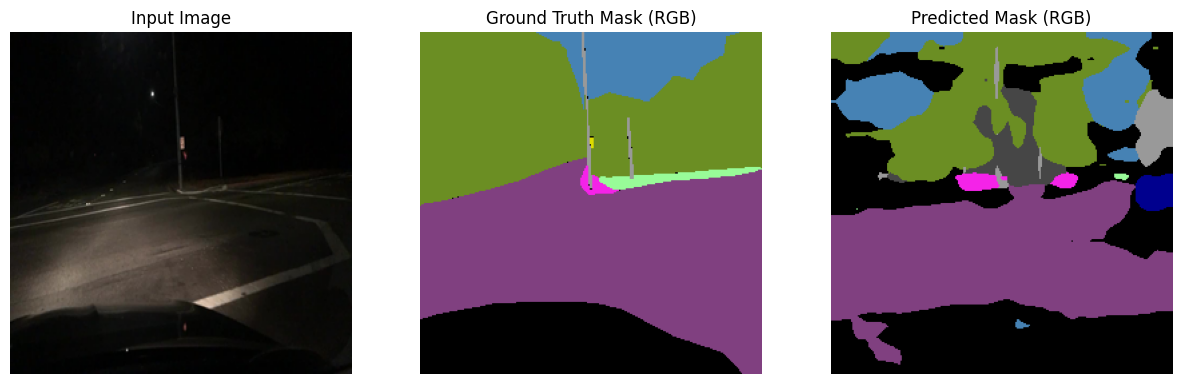

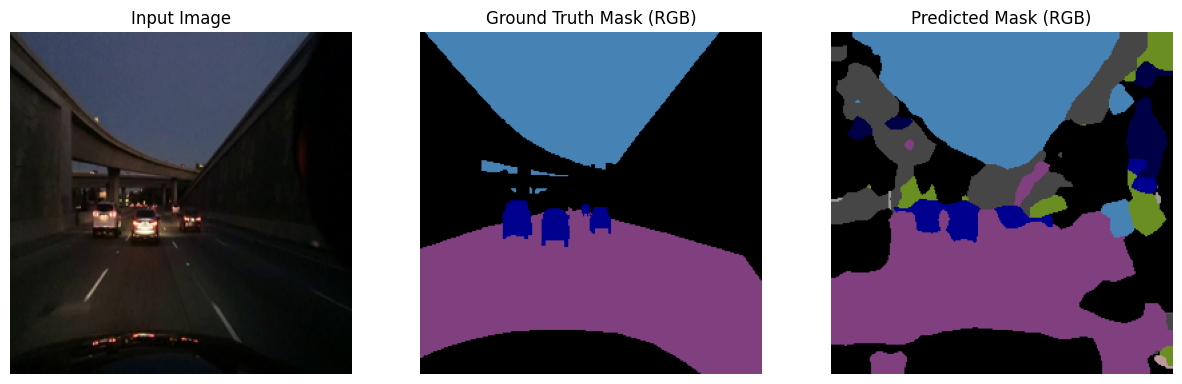

In [16]:
# Example usage:
num_classes = 20  # Adjust as per your dataset
visualize_predictions_rgb(model, test_night_dataloader, num_classes, max_images=5)


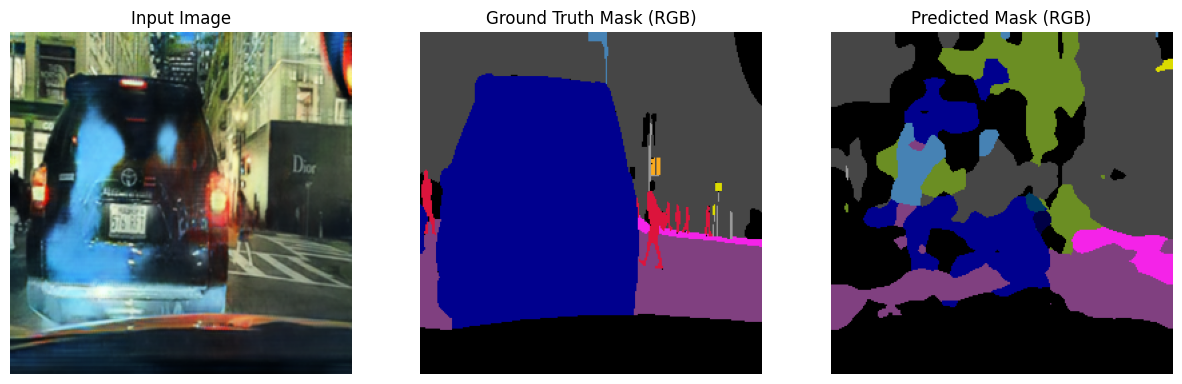

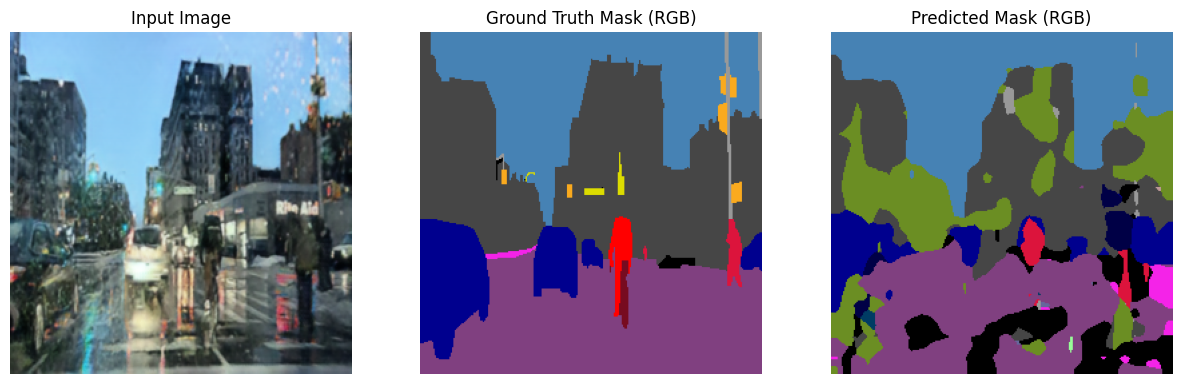

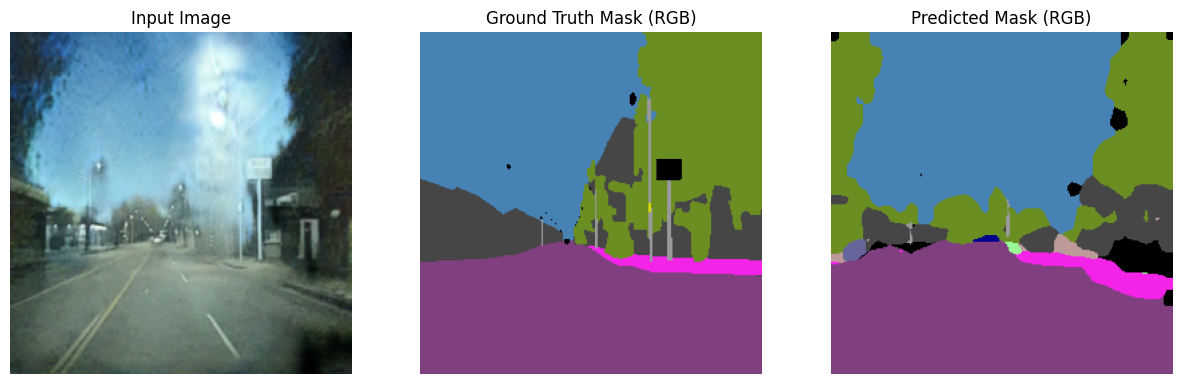

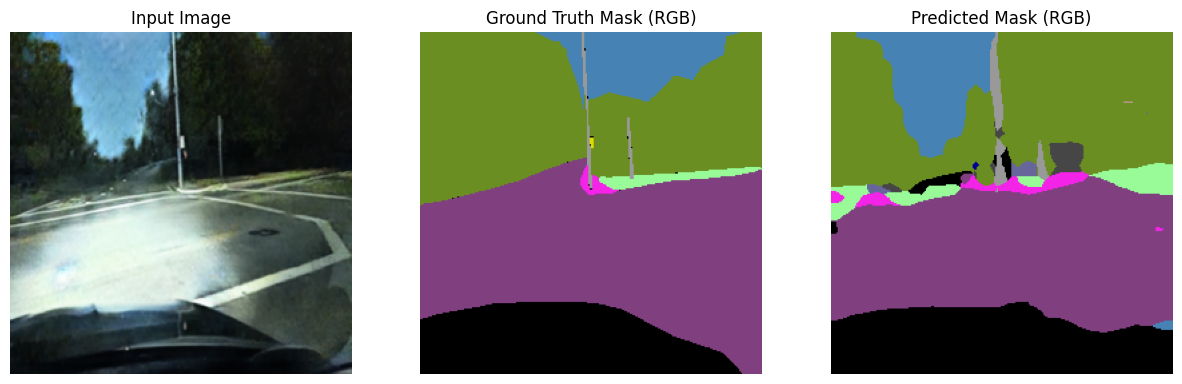

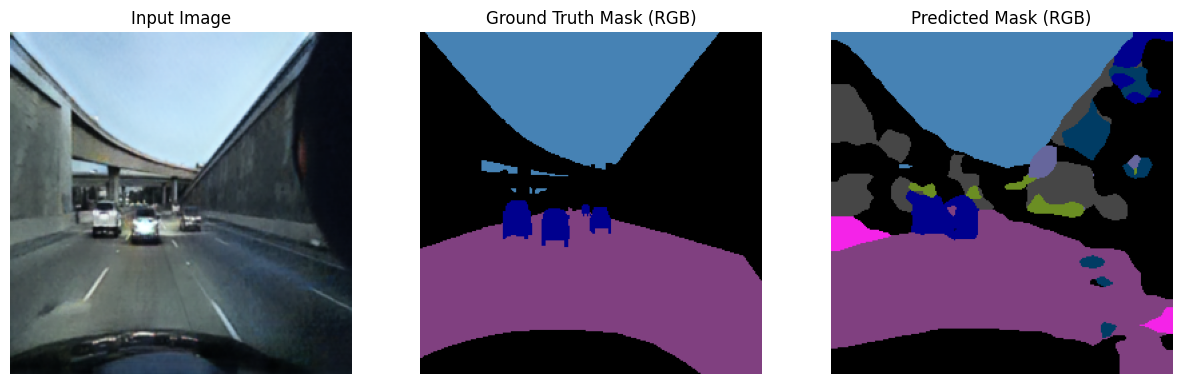

In [17]:
# Example usage:
num_classes = 20  # Adjust as per your dataset
visualize_predictions_rgb(model, test_cyclegan_dataloader, num_classes, max_images=5)


In [18]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Define BGR color classes
BGR_classes = {
    'road': np.array([128, 64, 128], dtype=np.uint8),
    'sidewalk': np.array([244, 35, 232], dtype=np.uint8),
    'building': np.array([70, 70, 70], dtype=np.uint8),
    'wall': np.array([102, 102, 156], dtype=np.uint8),
    'fence': np.array([190, 153, 153], dtype=np.uint8),
    'pole': np.array([153, 153, 153], dtype=np.uint8),
    'traffic light': np.array([250, 170, 30], dtype=np.uint8),
    'traffic sign': np.array([220, 220, 0], dtype=np.uint8),
    'vegetation': np.array([107, 142, 35], dtype=np.uint8),
    'terrain': np.array([152, 251, 152], dtype=np.uint8),
    'sky': np.array([70, 130, 180], dtype=np.uint8),
    'person': np.array([220, 20, 60], dtype=np.uint8),
    'rider': np.array([255, 0, 0], dtype=np.uint8),
    'car': np.array([0, 0, 142], dtype=np.uint8),
    'truck': np.array([0, 0, 70], dtype=np.uint8),
    'bus': np.array([0, 60, 100], dtype=np.uint8),
    'train': np.array([0, 80, 100], dtype=np.uint8),
    'motorcycle': np.array([0, 0, 230], dtype=np.uint8),
    'bicycle': np.array([119, 11, 32], dtype=np.uint8),
    'unknown': np.array([0, 0, 0], dtype=np.uint8)
}

# Create a color map array for the classes
color_map = np.array(list(BGR_classes.values()), dtype=np.uint8)

# Ensure the model is in evaluation mode and moved to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Directory to save predicted masks
predicted_masks_dir = 'predicted_masks_output_day1'  # Adjust path if needed
os.makedirs(predicted_masks_dir, exist_ok=True)

# Get list of image paths from the test dataset
image_paths = val_day_dataset.images  # Make sure to use the correct variable for test images

# Perform predictions and save results
for img_path in image_paths:
    # Load the image and create tensor
    image = plt.imread(img_path)[:, :, :3]  # Load image and ignore alpha channel if present
    image = np.moveaxis(image, -1, 0)  # Move channel dimension to first
    image_tensor = torch.tensor(image).float().unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
    
    # The output is an OrderedDict with 'out' key containing the predicted mask
    pred_mask = output['out']  # Access the predicted mask tensor
    
    # Convert predictions to CPU and to numpy format
    pred_mask = pred_mask.cpu().numpy().squeeze(0)  # Remove batch dimension

    # Get the class with the highest score
    pred_class = pred_mask.argmax(axis=0)

    # Convert class indices to RGB using the color map
    rgb_img = color_map[pred_class]

    # Extract the original image name
    img_filename = os.path.basename(img_path)  # Get the original image name

    # Create the full path for saving the predicted mask
    img_mask_filename = os.path.join(predicted_masks_dir, img_filename)

    # Save the predicted mask
    Image.fromarray(rgb_img.astype(np.uint8)).save(img_mask_filename)

# Print a final statement when all masks are saved
print(f'Predicted masks saved to {predicted_masks_dir}')


Predicted masks saved to predicted_masks_output_day1


In [19]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Define BGR color classes
BGR_classes = {
    'road': np.array([128, 64, 128], dtype=np.uint8),
    'sidewalk': np.array([244, 35, 232], dtype=np.uint8),
    'building': np.array([70, 70, 70], dtype=np.uint8),
    'wall': np.array([102, 102, 156], dtype=np.uint8),
    'fence': np.array([190, 153, 153], dtype=np.uint8),
    'pole': np.array([153, 153, 153], dtype=np.uint8),
    'traffic light': np.array([250, 170, 30], dtype=np.uint8),
    'traffic sign': np.array([220, 220, 0], dtype=np.uint8),
    'vegetation': np.array([107, 142, 35], dtype=np.uint8),
    'terrain': np.array([152, 251, 152], dtype=np.uint8),
    'sky': np.array([70, 130, 180], dtype=np.uint8),
    'person': np.array([220, 20, 60], dtype=np.uint8),
    'rider': np.array([255, 0, 0], dtype=np.uint8),
    'car': np.array([0, 0, 142], dtype=np.uint8),
    'truck': np.array([0, 0, 70], dtype=np.uint8),
    'bus': np.array([0, 60, 100], dtype=np.uint8),
    'train': np.array([0, 80, 100], dtype=np.uint8),
    'motorcycle': np.array([0, 0, 230], dtype=np.uint8),
    'bicycle': np.array([119, 11, 32], dtype=np.uint8),
    'unknown': np.array([0, 0, 0], dtype=np.uint8)
}

# Create a color map array for the classes
color_map = np.array(list(BGR_classes.values()), dtype=np.uint8)

# Ensure the model is in evaluation mode and moved to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Directory to save predicted masks
predicted_masks_dir = 'predicted_masks_output_night1'  # Adjust path if needed
os.makedirs(predicted_masks_dir, exist_ok=True)

# Get list of image paths from the test dataset
image_paths = val_night_dataset.images  # Make sure to use the correct variable for test images

# Perform predictions and save results
for img_path in image_paths:
    # Load the image and create tensor
    image = plt.imread(img_path)[:, :, :3]  # Load image and ignore alpha channel if present
    image = np.moveaxis(image, -1, 0)  # Move channel dimension to first
    image_tensor = torch.tensor(image).float().unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
    
    # The output is an OrderedDict with 'out' key containing the predicted mask
    pred_mask = output['out']  # Access the predicted mask tensor
    
    # Convert predictions to CPU and to numpy format
    pred_mask = pred_mask.cpu().numpy().squeeze(0)  # Remove batch dimension

    # Get the class with the highest score
    pred_class = pred_mask.argmax(axis=0)

    # Convert class indices to RGB using the color map
    rgb_img = color_map[pred_class]

    # Extract the original image name
    img_filename = os.path.basename(img_path)  # Get the original image name

    # Create the full path for saving the predicted mask
    img_mask_filename = os.path.join(predicted_masks_dir, img_filename)

    # Save the predicted mask
    Image.fromarray(rgb_img.astype(np.uint8)).save(img_mask_filename)

# Print a final statement when all masks are saved
print(f'Predicted masks saved to {predicted_masks_dir}')


Predicted masks saved to predicted_masks_output_night1


In [20]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Define BGR color classes
BGR_classes = {
    'road': np.array([128, 64, 128], dtype=np.uint8),
    'sidewalk': np.array([244, 35, 232], dtype=np.uint8),
    'building': np.array([70, 70, 70], dtype=np.uint8),
    'wall': np.array([102, 102, 156], dtype=np.uint8),
    'fence': np.array([190, 153, 153], dtype=np.uint8),
    'pole': np.array([153, 153, 153], dtype=np.uint8),
    'traffic light': np.array([250, 170, 30], dtype=np.uint8),
    'traffic sign': np.array([220, 220, 0], dtype=np.uint8),
    'vegetation': np.array([107, 142, 35], dtype=np.uint8),
    'terrain': np.array([152, 251, 152], dtype=np.uint8),
    'sky': np.array([70, 130, 180], dtype=np.uint8),
    'person': np.array([220, 20, 60], dtype=np.uint8),
    'rider': np.array([255, 0, 0], dtype=np.uint8),
    'car': np.array([0, 0, 142], dtype=np.uint8),
    'truck': np.array([0, 0, 70], dtype=np.uint8),
    'bus': np.array([0, 60, 100], dtype=np.uint8),
    'train': np.array([0, 80, 100], dtype=np.uint8),
    'motorcycle': np.array([0, 0, 230], dtype=np.uint8),
    'bicycle': np.array([119, 11, 32], dtype=np.uint8),
    'unknown': np.array([0, 0, 0], dtype=np.uint8)
}

# Create a color map array for the classes
color_map = np.array(list(BGR_classes.values()), dtype=np.uint8)

# Ensure the model is in evaluation mode and moved to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Directory to save predicted masks
predicted_masks_dir = 'predicted_masks_output_cyclegan1'  # Adjust path if needed
os.makedirs(predicted_masks_dir, exist_ok=True)

# Get list of image paths from the test dataset
image_paths = val_cyclegan_dataset.images  # Make sure to use the correct variable for test images

# Perform predictions and save results
for img_path in image_paths:
    # Load the image and create tensor
    image = plt.imread(img_path)[:, :, :3]  # Load image and ignore alpha channel if present
    image = np.moveaxis(image, -1, 0)  # Move channel dimension to first
    image_tensor = torch.tensor(image).float().unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
    
    # The output is an OrderedDict with 'out' key containing the predicted mask
    pred_mask = output['out']  # Access the predicted mask tensor
    
    # Convert predictions to CPU and to numpy format
    pred_mask = pred_mask.cpu().numpy().squeeze(0)  # Remove batch dimension

    # Get the class with the highest score
    pred_class = pred_mask.argmax(axis=0)

    # Convert class indices to RGB using the color map
    rgb_img = color_map[pred_class]

    # Extract the original image name
    img_filename = os.path.basename(img_path)  # Get the original image name

    # Create the full path for saving the predicted mask
    img_mask_filename = os.path.join(predicted_masks_dir, img_filename)

    # Save the predicted mask
    Image.fromarray(rgb_img.astype(np.uint8)).save(img_mask_filename)

# Print a final statement when all masks are saved
print(f'Predicted masks saved to {predicted_masks_dir}')


Predicted masks saved to predicted_masks_output_cyclegan1


Dataset-wide Average IoU: 0.5342270603372126
Dataset-wide Class-wise IoU:
road: 0.7559938663138864
sidewalk: 0.29996798858084456
building: 0.5774219036133996
wall: 0.12194618898823335
fence: 0.054758387845537035
pole: 0.07015236792734031
traffic light: 0.06244500498621458
traffic sign: 0.2609471246242547
vegetation: 0.6619201893938377
terrain: 0.2367751493289751
sky: 0.9016493796355021
person: 0.07680982207471365
rider: 0.0
car: 0.6421434302902304
truck: 0.17145488346472956
bus: 0.3352047091074664
train: 0.0
motorcycle: 0.003076923076923077
bicycle: 0.0
unknown: 0.0


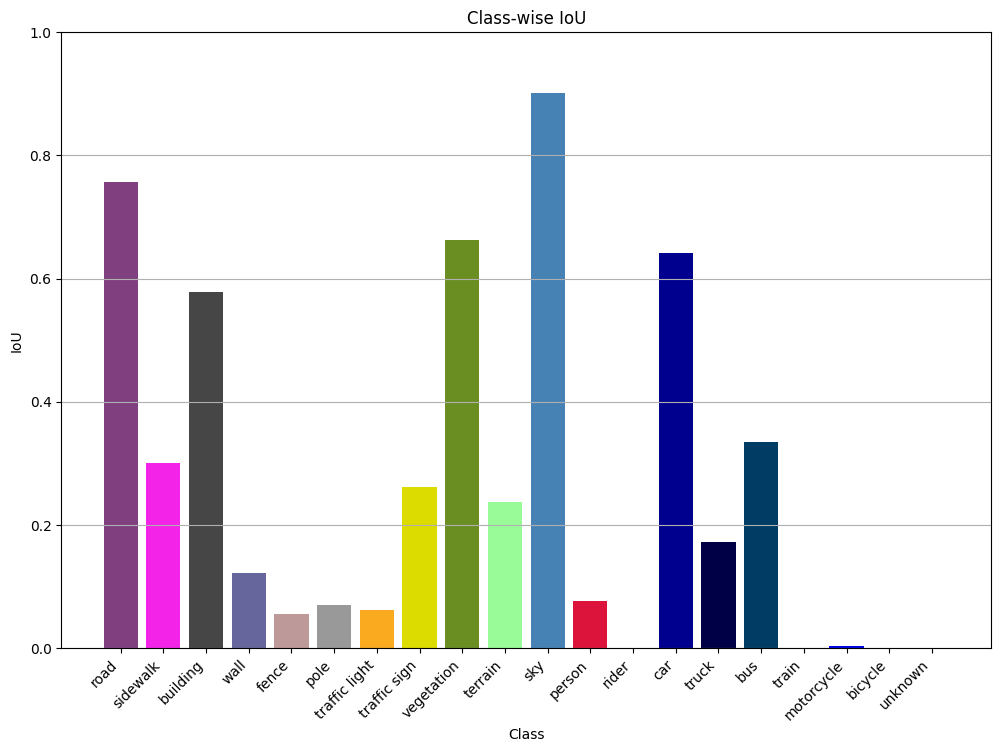

In [21]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import glob

def get_unique_pixels(image_path):
    """Get unique pixel values from an RGB image."""
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Failed to read image: {image_path}. Check if the file exists and is not corrupted.")
        return None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image_rgb.reshape(-1, image_rgb.shape[-1])
    unique_pixels = np.unique(pixels, axis=0)

    return unique_pixels, image_rgb

def map_pixels_to_classes(unique_pixels, color_dict):
    """Map unique pixels to class IDs using the color dictionary."""
    pixel_to_class = {}
    for pixel in unique_pixels:
        pixel_tuple = tuple(pixel)
        if pixel_tuple in color_dict:
            pixel_to_class[pixel_tuple] = color_dict[pixel_tuple]
        else:
            print(f"Pixel {pixel_tuple} not found in color dictionary.")
    return pixel_to_class

def map_image_to_class(image_rgb, pixel_to_class):
    """Map the entire image to class IDs using the pixel to class mapping."""
    class_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
    for pixel_tuple, class_id in pixel_to_class.items():
        mask_indices = np.all(image_rgb == np.array(pixel_tuple), axis=-1)
        class_mask[mask_indices] = class_id
    return class_mask

def read_mask(filepath, color_dict, target_shape=None):
    """Read and convert mask to class ID mask."""
    unique_pixels, image_rgb = get_unique_pixels(filepath)
    if unique_pixels is None:
        return None

    if target_shape:
        image_rgb = cv2.resize(image_rgb, target_shape, interpolation=cv2.INTER_NEAREST)

    pixel_to_class = map_pixels_to_classes(unique_pixels, color_dict)
    class_mask = map_image_to_class(image_rgb, pixel_to_class)
   
    return class_mask


def calculate_iou(mask_true, mask_pred, num_classes, ignore_class=19):
    """Calculate the intersection and union for IoU calculation."""
    intersection = np.histogram2d(mask_true.flatten(), mask_pred.flatten(), bins=(num_classes, num_classes), range=[[0, num_classes], [0, num_classes]])[0]
    area_true = np.histogram(mask_true, bins=num_classes, range=(0, num_classes))[0]
    area_pred = np.histogram(mask_pred, bins=num_classes, range=(0, num_classes))[0]
    area_union = area_true[:, None] + area_pred[None, :] - intersection

    # Set the class we want to ignore to zero
    area_true[ignore_class] = 0
    area_pred[ignore_class] = 0
    intersection[ignore_class] = 0
    area_union[ignore_class, :] = 0
    area_union[:, ignore_class] = 0

    relevant_classes = area_true > 0
    iou_per_class = np.divide(intersection, area_union, out=np.zeros_like(intersection, dtype=float), where=area_union != 0)
    valid_iou = np.diag(iou_per_class)

    # Exclude the ignored class from overall IoU calculation
    valid_iou = valid_iou[valid_iou != 0]  # Remove zeros that represent ignored class
    overall_iou = np.nanmean(valid_iou) if valid_iou.size > 0 else 0

    return overall_iou, valid_iou, relevant_classes

def main(color_dict, true_dir, pred_dir, num_classes):
    total_iou = 0
    num_images = 0
    total_intersection = np.zeros((num_classes, num_classes))
    total_union = np.zeros((num_classes, num_classes))

    for true_path in glob.glob(os.path.join(true_dir, '*.png')):  # Change extension if needed
        filename = os.path.basename(true_path)
        pred_path = os.path.join(pred_dir, filename)

        if not os.path.exists(pred_path):
            print(f"Prediction mask not found for {filename}")
            continue

        mask_true = read_mask(true_path, color_dict)
        mask_pred = read_mask(pred_path, color_dict)

        if mask_true is None or mask_pred is None:
            print(f"Failed to read masks for {filename}")
            continue

        # Ensure both masks are of the same shape
        if mask_true.shape != mask_pred.shape:
            print(f"Shape mismatch for {filename}: true mask shape = {mask_true.shape}, predicted mask shape = {mask_pred.shape}")
            continue

        overall_iou, class_iou, relevant_classes = calculate_iou(mask_true, mask_pred, num_classes, ignore_class=19)
        total_iou += overall_iou
        num_images += 1


        # Update intersection and union for class-wise IoU
        # Update intersection and union for class-wise IoU while ignoring class 19
        intersection = np.histogram2d(mask_true.flatten(), mask_pred.flatten(), bins=(num_classes, num_classes), range=[[0, num_classes], [0, num_classes]])[0]
        area_true = np.histogram(mask_true, bins=num_classes, range=(0, num_classes))[0]
        area_pred = np.histogram(mask_pred, bins=num_classes, range=(0, num_classes))[0]
        area_union = area_true[:, None] + area_pred[None, :] - intersection

# Ignore class 19 in the total calculations
        intersection[19] = 0
        area_union[19, :] = 0
        area_union[:, 19] = 0

        total_intersection += intersection
        total_union += area_union

    dataset_iou = total_iou / num_images if num_images > 0 else 0
    dataset_class_iou = np.divide(np.diag(total_intersection), np.diag(total_union), out=np.zeros_like(np.diag(total_intersection), dtype=float), where=np.diag(total_union) != 0)

    return dataset_iou, dataset_class_iou


# Define parameters
color_dict = {
    (128, 64, 128): 0,      # Road
    (244, 35, 232): 1,      # Sidewalk
    (70, 70, 70): 2,        # Building
    (102, 102, 156): 3,     # Wall
    (190, 153, 153): 4,     # Fence
    (153, 153, 153): 5,     # Pole
    (250, 170, 30): 6,      # Traffic Light
    (220, 220, 0): 7,       # Traffic Sign
    (107, 142, 35): 8,      # Vegetation
    (152, 251, 152): 9,     # Terrain
    (70, 130, 180): 10,     # Sky
    (220, 20, 60): 11,      # Person
    (255, 0, 0): 12,        # Rider
    (0, 0, 142): 13,        # Car
    (0, 0, 70): 14,         # Truck
    (0, 60, 100): 15,       # Bus
    (0, 80, 100): 16,       # Train
    (0, 0, 230): 17,        # Motorcycle
    (119, 11, 32): 18,      # Bicycle
    (0, 0, 0): 19           # Unknown
}


true_mask_dir = '/kaggle/input/png-images-new/new/val_png_masks_250'
predicted_mask_dir = '/kaggle/working/predicted_masks_output_day1'
num_classes = len(color_dict)

dataset_iou, dataset_class_iou = main(color_dict, true_mask_dir, predicted_mask_dir, num_classes)
print(f"Dataset-wide Average IoU: {dataset_iou}")

class_labels = [
    "road", "sidewalk", "building", "wall", "fence", "pole",
    "traffic light", "traffic sign", "vegetation", "terrain",
    "sky", "person", "rider", "car", "truck", "bus",
    "train", "motorcycle", "bicycle", "unknown"
]


# Print class-wise IoU with labels
print("Dataset-wide Class-wise IoU:")
for label, iou in zip(class_labels, dataset_class_iou):
    print(f"{label}: {iou}")

# Convert class colors to matplotlib compatible format
class_colors_rgb = [np.array(k) / 255 for k in color_dict.keys()]

# Plotting the class-wise IoU as a bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(class_labels, dataset_class_iou, color=class_colors_rgb)
plt.xlabel('Class')
plt.ylabel('IoU')
plt.title('Class-wise IoU')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y')

# Save the figure
plt.savefig('class_wise_iou_unet_19_day.png')

# Display the plot
plt.show()

Dataset-wide Average IoU: 0.35230997668024183
Dataset-wide Class-wise IoU:
road: 0.6181151802093985
sidewalk: 0.10435546052777347
building: 0.3489580940154398
wall: 0.013190290457133672
fence: 0.01195320967708951
pole: 0.03664736889051237
traffic light: 0.0016304720147975612
traffic sign: 0.0060617586231487865
vegetation: 0.2218747447526483
terrain: 0.04440047635569142
sky: 0.3205680373068259
person: 0.05346204958223227
rider: 0.0
car: 0.42952327063240964
truck: 0.042086057473012015
bus: 0.07632982938038138
train: 0.0
motorcycle: 0.0
bicycle: 0.0
unknown: 0.0


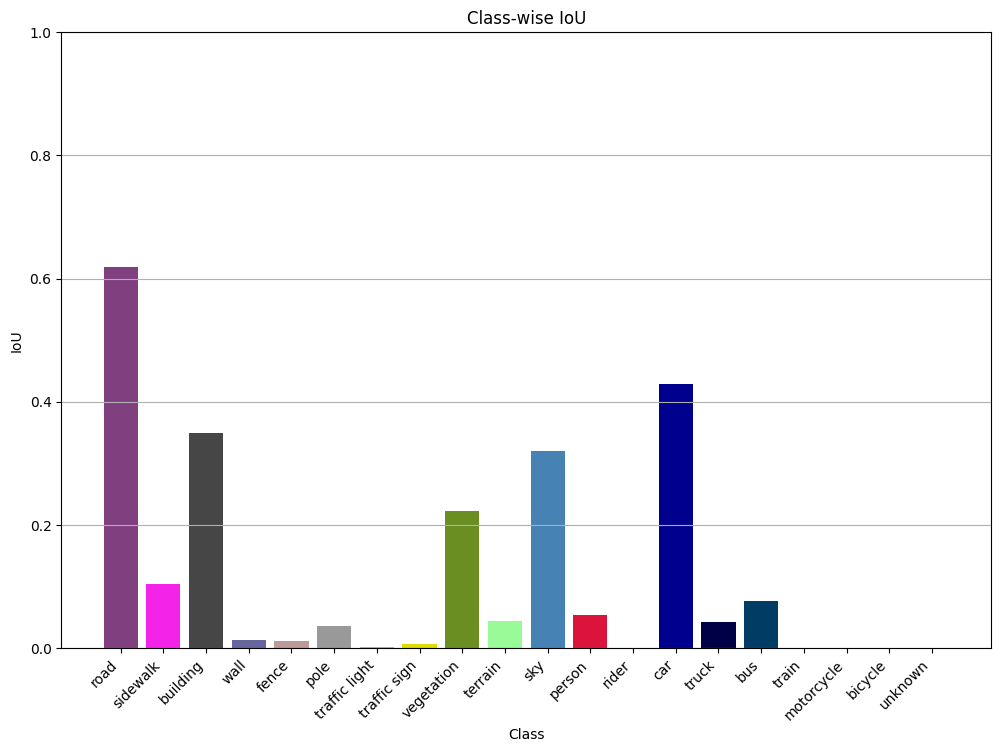

In [22]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import glob

def get_unique_pixels(image_path):
    """Get unique pixel values from an RGB image."""
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Failed to read image: {image_path}. Check if the file exists and is not corrupted.")
        return None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image_rgb.reshape(-1, image_rgb.shape[-1])
    unique_pixels = np.unique(pixels, axis=0)

    return unique_pixels, image_rgb

def map_pixels_to_classes(unique_pixels, color_dict):
    """Map unique pixels to class IDs using the color dictionary."""
    pixel_to_class = {}
    for pixel in unique_pixels:
        pixel_tuple = tuple(pixel)
        if pixel_tuple in color_dict:
            pixel_to_class[pixel_tuple] = color_dict[pixel_tuple]
        else:
            print(f"Pixel {pixel_tuple} not found in color dictionary.")
    return pixel_to_class

def map_image_to_class(image_rgb, pixel_to_class):
    """Map the entire image to class IDs using the pixel to class mapping."""
    class_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
    for pixel_tuple, class_id in pixel_to_class.items():
        mask_indices = np.all(image_rgb == np.array(pixel_tuple), axis=-1)
        class_mask[mask_indices] = class_id
    return class_mask

def read_mask(filepath, color_dict, target_shape=None):
    """Read and convert mask to class ID mask."""
    unique_pixels, image_rgb = get_unique_pixels(filepath)
    if unique_pixels is None:
        return None

    if target_shape:
        image_rgb = cv2.resize(image_rgb, target_shape, interpolation=cv2.INTER_NEAREST)

    pixel_to_class = map_pixels_to_classes(unique_pixels, color_dict)
    class_mask = map_image_to_class(image_rgb, pixel_to_class)
   
    return class_mask


def calculate_iou(mask_true, mask_pred, num_classes, ignore_class=19):
    """Calculate the intersection and union for IoU calculation."""
    intersection = np.histogram2d(mask_true.flatten(), mask_pred.flatten(), bins=(num_classes, num_classes), range=[[0, num_classes], [0, num_classes]])[0]
    area_true = np.histogram(mask_true, bins=num_classes, range=(0, num_classes))[0]
    area_pred = np.histogram(mask_pred, bins=num_classes, range=(0, num_classes))[0]
    area_union = area_true[:, None] + area_pred[None, :] - intersection

    # Set the class we want to ignore to zero
    area_true[ignore_class] = 0
    area_pred[ignore_class] = 0
    intersection[ignore_class] = 0
    area_union[ignore_class, :] = 0
    area_union[:, ignore_class] = 0

    relevant_classes = area_true > 0
    iou_per_class = np.divide(intersection, area_union, out=np.zeros_like(intersection, dtype=float), where=area_union != 0)
    valid_iou = np.diag(iou_per_class)

    # Exclude the ignored class from overall IoU calculation
    valid_iou = valid_iou[valid_iou != 0]  # Remove zeros that represent ignored class
    overall_iou = np.nanmean(valid_iou) if valid_iou.size > 0 else 0

    return overall_iou, valid_iou, relevant_classes

def main(color_dict, true_dir, pred_dir, num_classes):
    total_iou = 0
    num_images = 0
    total_intersection = np.zeros((num_classes, num_classes))
    total_union = np.zeros((num_classes, num_classes))

    for true_path in glob.glob(os.path.join(true_dir, '*.png')):  # Change extension if needed
        filename = os.path.basename(true_path)
        pred_path = os.path.join(pred_dir, filename)

        if not os.path.exists(pred_path):
            print(f"Prediction mask not found for {filename}")
            continue

        mask_true = read_mask(true_path, color_dict)
        mask_pred = read_mask(pred_path, color_dict)

        if mask_true is None or mask_pred is None:
            print(f"Failed to read masks for {filename}")
            continue

        # Ensure both masks are of the same shape
        if mask_true.shape != mask_pred.shape:
            print(f"Shape mismatch for {filename}: true mask shape = {mask_true.shape}, predicted mask shape = {mask_pred.shape}")
            continue

        overall_iou, class_iou, relevant_classes = calculate_iou(mask_true, mask_pred, num_classes, ignore_class=19)
        total_iou += overall_iou
        num_images += 1


        # Update intersection and union for class-wise IoU
        # Update intersection and union for class-wise IoU while ignoring class 19
        intersection = np.histogram2d(mask_true.flatten(), mask_pred.flatten(), bins=(num_classes, num_classes), range=[[0, num_classes], [0, num_classes]])[0]
        area_true = np.histogram(mask_true, bins=num_classes, range=(0, num_classes))[0]
        area_pred = np.histogram(mask_pred, bins=num_classes, range=(0, num_classes))[0]
        area_union = area_true[:, None] + area_pred[None, :] - intersection

# Ignore class 19 in the total calculations
        intersection[19] = 0
        area_union[19, :] = 0
        area_union[:, 19] = 0

        total_intersection += intersection
        total_union += area_union

    dataset_iou = total_iou / num_images if num_images > 0 else 0
    dataset_class_iou = np.divide(np.diag(total_intersection), np.diag(total_union), out=np.zeros_like(np.diag(total_intersection), dtype=float), where=np.diag(total_union) != 0)

    return dataset_iou, dataset_class_iou


# Define parameters
color_dict = {
    (128, 64, 128): 0,      # Road
    (244, 35, 232): 1,      # Sidewalk
    (70, 70, 70): 2,        # Building
    (102, 102, 156): 3,     # Wall
    (190, 153, 153): 4,     # Fence
    (153, 153, 153): 5,     # Pole
    (250, 170, 30): 6,      # Traffic Light
    (220, 220, 0): 7,       # Traffic Sign
    (107, 142, 35): 8,      # Vegetation
    (152, 251, 152): 9,     # Terrain
    (70, 130, 180): 10,     # Sky
    (220, 20, 60): 11,      # Person
    (255, 0, 0): 12,        # Rider
    (0, 0, 142): 13,        # Car
    (0, 0, 70): 14,         # Truck
    (0, 60, 100): 15,       # Bus
    (0, 80, 100): 16,       # Train
    (0, 0, 230): 17,        # Motorcycle
    (119, 11, 32): 18,      # Bicycle
    (0, 0, 0): 19           # Unknown
}


true_mask_dir = '/kaggle/input/masksnew/val__night_png_masksnew_250'
predicted_mask_dir = '/kaggle/working/predicted_masks_output_night1'
num_classes = len(color_dict)

dataset_iou, dataset_class_iou = main(color_dict, true_mask_dir, predicted_mask_dir, num_classes)
print(f"Dataset-wide Average IoU: {dataset_iou}")

class_labels = [
    "road", "sidewalk", "building", "wall", "fence", "pole",
    "traffic light", "traffic sign", "vegetation", "terrain",
    "sky", "person", "rider", "car", "truck", "bus",
    "train", "motorcycle", "bicycle", "unknown"
]


# Print class-wise IoU with labels
print("Dataset-wide Class-wise IoU:")
for label, iou in zip(class_labels, dataset_class_iou):
    print(f"{label}: {iou}")

# Convert class colors to matplotlib compatible format
class_colors_rgb = [np.array(k) / 255 for k in color_dict.keys()]

# Plotting the class-wise IoU as a bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(class_labels, dataset_class_iou, color=class_colors_rgb)
plt.xlabel('Class')
plt.ylabel('IoU')
plt.title('Class-wise IoU')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y')

# Save the figure
plt.savefig('class_wise_iou_unet_19_night.png')

# Display the plot
plt.show()

Dataset-wide Average IoU: 0.3748910706140465
Dataset-wide Class-wise IoU:
road: 0.6586676973198767
sidewalk: 0.14640023934516658
building: 0.38962980622748394
wall: 0.033226338721736665
fence: 0.026471506763753514
pole: 0.05113121062823247
traffic light: 0.0013181818181818182
traffic sign: 0.002277493091141385
vegetation: 0.23059740527968786
terrain: 0.05649923102273976
sky: 0.3466187862603668
person: 0.07365693739424704
rider: 0.0
car: 0.462652017781575
truck: 0.04782961020399048
bus: 0.07941393396119369
train: 0.0
motorcycle: 0.0
bicycle: 0.0
unknown: 0.0


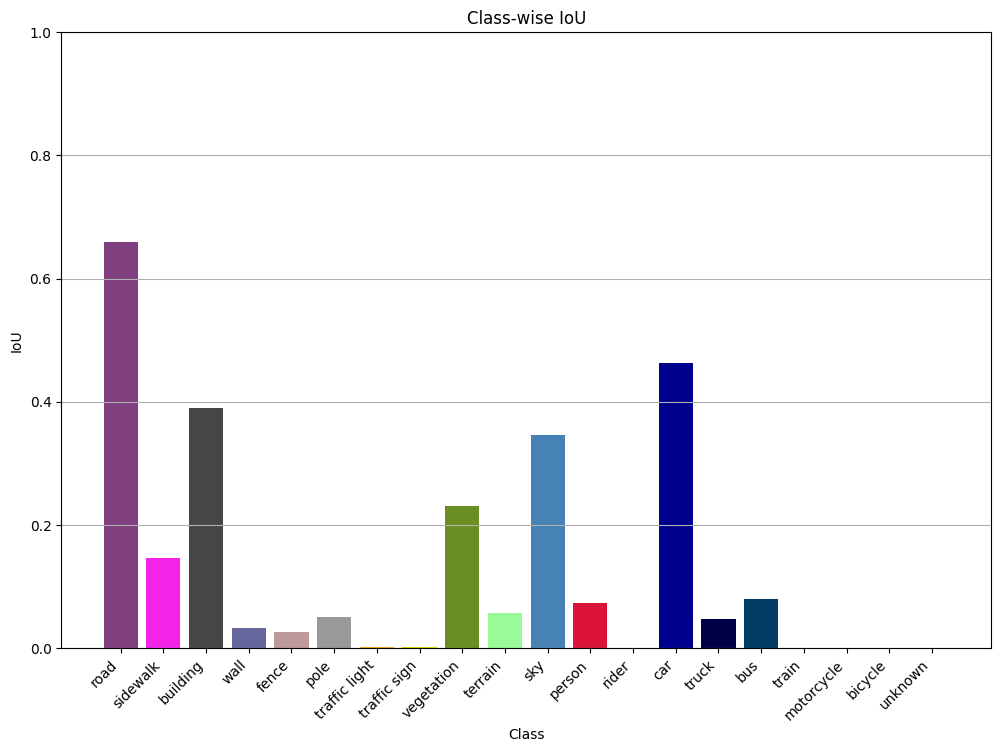

In [23]:

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import glob

def get_unique_pixels(image_path):
    """Get unique pixel values from an RGB image."""
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Failed to read image: {image_path}. Check if the file exists and is not corrupted.")
        return None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image_rgb.reshape(-1, image_rgb.shape[-1])
    unique_pixels = np.unique(pixels, axis=0)

    return unique_pixels, image_rgb

def map_pixels_to_classes(unique_pixels, color_dict):
    """Map unique pixels to class IDs using the color dictionary."""
    pixel_to_class = {}
    for pixel in unique_pixels:
        pixel_tuple = tuple(pixel)
        if pixel_tuple in color_dict:
            pixel_to_class[pixel_tuple] = color_dict[pixel_tuple]
        else:
            print(f"Pixel {pixel_tuple} not found in color dictionary.")
    return pixel_to_class

def map_image_to_class(image_rgb, pixel_to_class):
    """Map the entire image to class IDs using the pixel to class mapping."""
    class_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
    for pixel_tuple, class_id in pixel_to_class.items():
        mask_indices = np.all(image_rgb == np.array(pixel_tuple), axis=-1)
        class_mask[mask_indices] = class_id
    return class_mask

def read_mask(filepath, color_dict, target_shape=None):
    """Read and convert mask to class ID mask."""
    unique_pixels, image_rgb = get_unique_pixels(filepath)
    if unique_pixels is None:
        return None

    if target_shape:
        image_rgb = cv2.resize(image_rgb, target_shape, interpolation=cv2.INTER_NEAREST)

    pixel_to_class = map_pixels_to_classes(unique_pixels, color_dict)
    class_mask = map_image_to_class(image_rgb, pixel_to_class)
   
    return class_mask


def calculate_iou(mask_true, mask_pred, num_classes, ignore_class=19):
    """Calculate the intersection and union for IoU calculation."""
    intersection = np.histogram2d(mask_true.flatten(), mask_pred.flatten(), bins=(num_classes, num_classes), range=[[0, num_classes], [0, num_classes]])[0]
    area_true = np.histogram(mask_true, bins=num_classes, range=(0, num_classes))[0]
    area_pred = np.histogram(mask_pred, bins=num_classes, range=(0, num_classes))[0]
    area_union = area_true[:, None] + area_pred[None, :] - intersection

    # Set the class we want to ignore to zero
    area_true[ignore_class] = 0
    area_pred[ignore_class] = 0
    intersection[ignore_class] = 0
    area_union[ignore_class, :] = 0
    area_union[:, ignore_class] = 0

    relevant_classes = area_true > 0
    iou_per_class = np.divide(intersection, area_union, out=np.zeros_like(intersection, dtype=float), where=area_union != 0)
    valid_iou = np.diag(iou_per_class)

    # Exclude the ignored class from overall IoU calculation
    valid_iou = valid_iou[valid_iou != 0]  # Remove zeros that represent ignored class
    overall_iou = np.nanmean(valid_iou) if valid_iou.size > 0 else 0

    return overall_iou, valid_iou, relevant_classes

def main(color_dict, true_dir, pred_dir, num_classes):
    total_iou = 0
    num_images = 0
    total_intersection = np.zeros((num_classes, num_classes))
    total_union = np.zeros((num_classes, num_classes))

    for true_path in glob.glob(os.path.join(true_dir, '*.png')):  # Change extension if needed
        filename = os.path.basename(true_path)
        pred_path = os.path.join(pred_dir, filename)

        if not os.path.exists(pred_path):
            print(f"Prediction mask not found for {filename}")
            continue

        mask_true = read_mask(true_path, color_dict)
        mask_pred = read_mask(pred_path, color_dict)

        if mask_true is None or mask_pred is None:
            print(f"Failed to read masks for {filename}")
            continue

        # Ensure both masks are of the same shape
        if mask_true.shape != mask_pred.shape:
            print(f"Shape mismatch for {filename}: true mask shape = {mask_true.shape}, predicted mask shape = {mask_pred.shape}")
            continue

        overall_iou, class_iou, relevant_classes = calculate_iou(mask_true, mask_pred, num_classes, ignore_class=19)
        total_iou += overall_iou
        num_images += 1


        # Update intersection and union for class-wise IoU
        # Update intersection and union for class-wise IoU while ignoring class 19
        intersection = np.histogram2d(mask_true.flatten(), mask_pred.flatten(), bins=(num_classes, num_classes), range=[[0, num_classes], [0, num_classes]])[0]
        area_true = np.histogram(mask_true, bins=num_classes, range=(0, num_classes))[0]
        area_pred = np.histogram(mask_pred, bins=num_classes, range=(0, num_classes))[0]
        area_union = area_true[:, None] + area_pred[None, :] - intersection

# Ignore class 19 in the total calculations
        intersection[19] = 0
        area_union[19, :] = 0
        area_union[:, 19] = 0

        total_intersection += intersection
        total_union += area_union

    dataset_iou = total_iou / num_images if num_images > 0 else 0
    dataset_class_iou = np.divide(np.diag(total_intersection), np.diag(total_union), out=np.zeros_like(np.diag(total_intersection), dtype=float), where=np.diag(total_union) != 0)

    return dataset_iou, dataset_class_iou


# Define parameters
color_dict = {
    (128, 64, 128): 0,      # Road
    (244, 35, 232): 1,      # Sidewalk
    (70, 70, 70): 2,        # Building
    (102, 102, 156): 3,     # Wall
    (190, 153, 153): 4,     # Fence
    (153, 153, 153): 5,     # Pole
    (250, 170, 30): 6,      # Traffic Light
    (220, 220, 0): 7,       # Traffic Sign
    (107, 142, 35): 8,      # Vegetation
    (152, 251, 152): 9,     # Terrain
    (70, 130, 180): 10,     # Sky
    (220, 20, 60): 11,      # Person
    (255, 0, 0): 12,        # Rider
    (0, 0, 142): 13,        # Car
    (0, 0, 70): 14,         # Truck
    (0, 60, 100): 15,       # Bus
    (0, 80, 100): 16,       # Train
    (0, 0, 230): 17,        # Motorcycle
    (119, 11, 32): 18,      # Bicycle
    (0, 0, 0): 19           # Unknown
}


true_mask_dir = '/kaggle/input/masksnew/val__night_png_masksnew_250'
predicted_mask_dir = '/kaggle/working/predicted_masks_output_cyclegan1'
num_classes = len(color_dict)

dataset_iou, dataset_class_iou = main(color_dict, true_mask_dir, predicted_mask_dir, num_classes)
print(f"Dataset-wide Average IoU: {dataset_iou}")

class_labels = [
    "road", "sidewalk", "building", "wall", "fence", "pole",
    "traffic light", "traffic sign", "vegetation", "terrain",
    "sky", "person", "rider", "car", "truck", "bus",
    "train", "motorcycle", "bicycle", "unknown"
]


# Print class-wise IoU with labels
print("Dataset-wide Class-wise IoU:")
for label, iou in zip(class_labels, dataset_class_iou):
    print(f"{label}: {iou}")

# Convert class colors to matplotlib compatible format
class_colors_rgb = [np.array(k) / 255 for k in color_dict.keys()]

# Plotting the class-wise IoU as a bar graph
plt.figure(figsize=(12, 8))
bars = plt.bar(class_labels, dataset_class_iou, color=class_colors_rgb)
plt.xlabel('Class')
plt.ylabel('IoU')
plt.title('Class-wise IoU')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y')

# Save the figure
plt.savefig('class_wise_iou_unet_19_cyclegan.png')

# Display the plot
plt.show()